In [1]:
# Just use IPydisplay to make an audio of input and output to compare if mono (unconvolved)
#   vs stereo (convolved). Localization shoudl still be at 0,0 but diff b/t LR signals + length
# t = np.arange(0, 30000, 1)
# plt.plot(t, *ew_out)

In [2]:
## Probably not needed

# def Convolve_HRTF(x, HRTF, keep_len=False):
    
    
#     N = x.size;
#     K = HRTF.shape[1];
#     output = np.ndarray(shape=(2, N+255), dtype=float);
    
# #     print("Expected: (n, m), m, 256")
# #     print(output.shape, x[1000], K)
    
#     for n in range(N):
#         for k in range(K):
#             output[0, n] = n * HRTF[0, k];
#             output[1, n] = n * HRTF[1, k];
    
# #     print("Expected: (n, m+255), M value diff if convolved")
# #     print(output.shape, x[1000], output[0, 1000])
    
#     if (keep_len):
#         return (output[0,0:N], output[1,0:N]);
#     else:
#         return output

In [3]:
# Script for Comparing the Frequency Response of the Neumann KU-100 and Earthworks M30 microphones
#   as recorded source (spoken voice) rotates 

# Overview

Purpose is for the comparison of Earthworks M30 and Neumann KU100 responses to a rotating sound source.\
\
Spectral similarity will be measured via comparison of the average spectral centroid of each of the 3 'takes'
    
## Flow 

 1. Read in recordings to EW_L, EW_R, and EW_mono
     1. Trim Lengths to be Same
 2. Read in HRIR at 0,0
 3. Convolve EW_mono with HRIR
 4. For each 'Track'
     1. Calculate Spectral Centroid over time
     2. Obtain Average
 3. For each Position (0, 45, 90, etc)
     1. Plot Fritz vs EW, then Fritz vs Convolved EW

In [4]:
# Step 0: Declare imports

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
import scipy.signal

In [5]:
## String formatting for Reading in Files


folder = "Soundfiles/"
tracknames = ["EW_", "Fritz_L_", "Fritz_R_"];
angles = ["00deg_", "45deg_", "90deg_", "135deg_", "180deg_", "225deg_", "270deg_", "315deg_"]
iterations = ["00", "01", "02"];
filetype = ".wav";

## Declare Data Structs

ew_raw = np.zeros((8, 3, 72000))
fritz_l_raw = np.zeros((8, 3, 72000))
fritz_r_raw = np.zeros((8, 3, 72000))

## Read in Files

for a in range(len(angles)):
    for i in range(len(iterations)):
        x, sr = librosa.load(folder + tracknames[0] + angles[a] + iterations[i] + filetype, sr=48000, mono=True);
        ew_raw[a, i] = x[0:72000]
        
        y, sr = librosa.load(folder + tracknames[1] + angles[a] + iterations[i] + filetype, sr=48000, mono=True);
        fritz_l_raw[a, i] = y[0:72000]
        
        z, sr = librosa.load(folder + tracknames[2] + angles[a] + iterations[i] + filetype, sr=48000, mono=True);
        fritz_r_raw[a, i] = z[0:72000]
        
#         print(folder + tracknames[0] + angles[a] + iterations[i] + filetype, y.size)
#         print(folder + tracknames[1] + angles[a] + iterations[i] + filetype, y.size)
#         print(folder + tracknames[2] + angles[a] + iterations[i] + filetype, y.size)


## Read in HRTF

# Also have HRIR at 90,0 for very distinguishable R/L channel data 
# hrtf, sr = librosa.load("Soundfiles/azi_90,0_ele_0,0.wav", sr=48000, mono=False);
hrtf, sr = librosa.load("Soundfiles/azi_0,0_ele_0,0.wav", sr=48000, mono=False);

In [6]:
# Part 2: Generate additional array of Earthworks stimuli convolved w/ Neuman KU-100 HRTF 
#   at azimuth, elevation (0,0)
#   HRTF courtesy of SADIE II database: https://www.york.ac.uk/sadie-project/database.html

ew_conv = np.zeros((8, 3, 2, 72000))

ew_conv_l = np.zeros((8, 3, 72000))
ew_conv_r = np.zeros((8, 3, 72000))

for a in range(len(angles)):
    for i in range(len(iterations)):
        ew_out_l = scipy.signal.fftconvolve(ew_raw[a][i], hrtf[0], mode='same');
        ew_out_r = scipy.signal.fftconvolve(ew_raw[a][i], hrtf[1], mode='same');
        
        ew_conv[a][i][0] = ew_out_l;
        ew_conv[a][i][1] = ew_out_r;

# print(ew_conv.shape)

# Audio(ew_conv[2][2], rate=48000)

In [7]:
# # Step 3: Calculate DFTs
# # x = get_dft(EW_x[6000:7512]);
# ew_stft = np.abs(librosa.stft(ew_raw[0][0]))
# S, phase = librosa.magphase(ew_stft)

# ew_stft0 = np.abs(librosa.stft(ew_raw[0][1]))
# S0, phase0 = librosa.magphase(ew_stft0)

# ew_stft1 = np.abs(librosa.stft(ew_raw[0][2]))
# S1, phase1 = librosa.magphase(ew_stft1)


In [8]:
# Potential Options for Feature Vectors: 
#   Spectral Centroid
#   Spectral Density
#   Cross-Power Spectral Density
#   MFCC's

# Problem with IR: wouldn't be distinctly different since the 
#   operative problem is the source rotating, not the placement?

# Other Problem: Likely need to repeat with identical phrases, because obviously

In [9]:
#  Spectral Centroid

## Declare Structs

ew_cent = np.zeros((8, 3, 141));
fritz_cent = np.zeros((8, 3, 2, 141));
ew_conv_cent = np.zeros((8, 3, 2, 141));

for a in range(len(angles)):
    for i in range(len(iterations)):

        ew_cent[a][i] = librosa.feature.spectral_centroid(ew_raw[a][i], sr=48000);
        fritz_cent[a][i][0] = librosa.feature.spectral_centroid(fritz_l_raw[a][i], sr=48000);
        fritz_cent[a][i][1] = librosa.feature.spectral_centroid(fritz_r_raw[a][i], sr=48000);
        ew_conv_cent[a][i][0] = librosa.feature.spectral_centroid(ew_conv[a][i][0], sr=48000);
        ew_conv_cent[a][i][1] = librosa.feature.spectral_centroid(ew_conv[a][i][1], sr=48000);

# mean_sc = np.mean((ew_sc, ew_sc0, ew_sc1), axis=0)


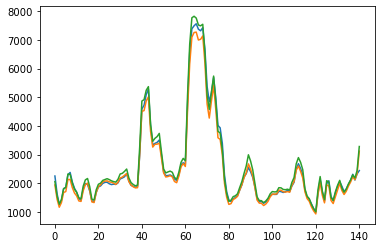

In [10]:
# Approach #1 - plot R/L difference and eyeball between

plt.plot(ew_cent[0][0])
# plt.plot(fritz_cent[3][0][0])
# plt.plot(fritz_cent[3][0][1])
plt.plot(ew_conv_cent[0][0][0])
plt.plot(ew_conv_cent[0][0][1])

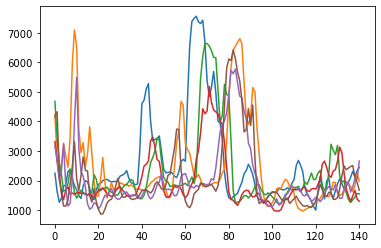

In [11]:
# Approach #2 - plot between-take diff and see if change is consistent

plt.plot(ew_cent[0][0])
plt.plot(ew_cent[1][0])
plt.plot(ew_cent[2][0])
plt.plot(ew_cent[3][0])
plt.plot(ew_cent[4][0])
plt.plot(ew_cent[5][0])

## Thoughts: Gross. Too noisy. Smooth w/ Average? 

In [148]:
## Do a spherical projection where -90 to 90 elevation is the frequency 
##   azimuth is azimuth
##   and amplitude at the frequency is colored and pushed out

    


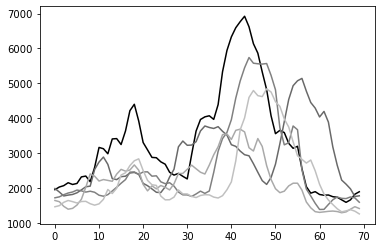

In [149]:
# Approach #3 - average SC

## Start and Stop indexes for getting a slice of the centroid (beg, end)

beg = 30;
end = 100;

# [beg:end]
slice_len = end-beg;

ew_cent_means = np.zeros((8, slice_len));
average_cent = np.zeros((8, 1));

fritz_cent_means = np.zeros((8, 2, slice_len));
fritz_mean_cent = np.zeros((8, 2));

ew_hrtf_means = np.zeros((8, 2, slice_len));
hrtf_mean_cent = np.zeros((8, 2));


for i in range(8):
    
    # Get the average of the spectral centroid across each angle for the EW 
    
    ew_cent_means[i] = np.mean((ew_cent[i][0][beg:end],ew_cent[i][1][beg:end],ew_cent[i][2][beg:end]), axis=0);
    average_cent[i] = np.mean(ew_cent_means[i])
    
    # Do the same for Fritz (missing)
    fritz_cent_means[i][0] = np.mean((fritz_cent[i][0][0][beg:end], fritz_cent[i][1][0][beg:end], fritz_cent[i][2][0][beg:end]))
    fritz_cent_means[i][1] = np.mean((fritz_cent[i][0][1][beg:end], fritz_cent[i][1][1][beg:end], fritz_cent[i][2][1][beg:end]))
    
    fritz_mean_cent[i][0] = np.mean(fritz_cent_means[i][0]);
    fritz_mean_cent[i][1] = np.mean(fritz_cent_means[i][1]);
    
    # Now do the same for each side of the Convolved Version
    ew_hrtf_means[i][0] = np.mean((ew_conv_cent[i][0][0][beg:end], ew_conv_cent[i][1][0][beg:end], ew_conv_cent[i][2][0][beg:end]))
    ew_hrtf_means[i][1] = np.mean((ew_conv_cent[i][0][1][beg:end], ew_conv_cent[i][1][1][beg:end], ew_conv_cent[i][2][1][beg:end]))
    
    hrtf_mean_cent[i][0] = np.mean(ew_hrtf_means[i][0]);
    hrtf_mean_cent[i][1] = np.mean(ew_hrtf_means[i][1]);
    
    
plt.plot(ew_cent_means[0], color='black')
plt.plot(ew_cent_means[1], color='dimgrey')
plt.plot(ew_cent_means[2], color='gray')
plt.plot(ew_cent_means[3], color='darkgrey')
plt.plot(ew_cent_means[4], color='silver')

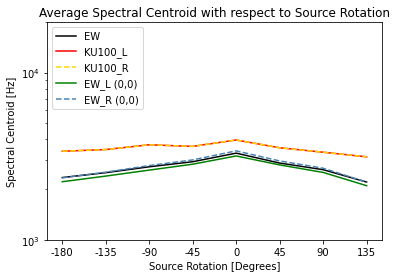

In [141]:
average_cent_rearr = np.append(average_cent[4:8], average_cent[0:4]);
fritz_mean_cent_rearr_l = np.append(fritz_mean_cent[4:8,0], fritz_mean_cent[0:4,0]);
fritz_mean_cent_rearr_r = np.append(fritz_mean_cent[4:8,1], fritz_mean_cent[0:4,1]);

hrtf_mean_cent_rearr_l = np.append(hrtf_mean_cent[4:8,0], hrtf_mean_cent[0:4,0]);
hrtf_mean_cent_rearr_r = np.append(hrtf_mean_cent[4:8,1], hrtf_mean_cent[0:4,1]);

# fig, ax = plt.subplots()

x = np.arange(8)
# y = np.logspace(20, 20000, 50);

plt.plot(x, average_cent_rearr, color = "black", label = 'EW')
plt.plot(x, fritz_mean_cent_rearr_l, color = 'red', label = 'KU100_L')
plt.plot(x, fritz_mean_cent_rearr_r, color = 'gold', label = 'KU100_R', ls='--')
plt.plot(x, hrtf_mean_cent_rearr_l, color = 'green', label = 'EW_L (0,0)')
plt.plot(x, hrtf_mean_cent_rearr_r, color = 'steelblue', label = 'EW_R (0,0)', ls='--')
plt.legend(loc = 'upper left')

plt.xticks(x ,['-180', '-135', '-90', '-45', '0', '45', '90', '135'])
plt.xlabel("Source Rotation [Degrees]")

plt.yscale('log')
plt.ylim(1000, 20000)
plt.ylabel("Spectral Centroid [Hz]")
plt.title("Average Spectral Centroid with respect to Source Rotation")

plt.show()

In [84]:
hrtf_mean_cent[0:8,]

array([[3174.11028123, 3404.30664615],
       [2805.87473804, 2963.87938818],
       [2530.06814551, 2680.62014053],
       [2107.39802278, 2212.44279056],
       [2225.82344919, 2347.01925192],
       [2405.70673496, 2538.60412601],
       [2612.22553299, 2780.58172703],
       [2833.37006989, 3006.60282074]])

In [53]:
import matplotlib.projections as proj

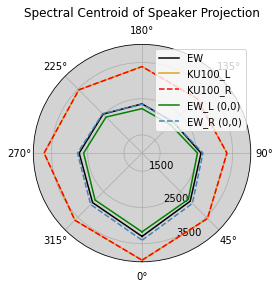

In [142]:
polar_xaxis = np.arange(0, (9/8 * (2 * np.pi)), (2 * np.pi)/8)
# plt.polar(polar_xaxis, np.append(average_cent, average_cent[0]));
# plt.polar(polar_xaxis, ew_hrtf_means[0:8,0]);

# plt.ylim((0, 3500));
# plt.yscale('symlog');
# plt.polar.RadialTick(["a","b"]);


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

     

ax.set_theta_zero_location("S", offset=0.0)
ax.set_theta_direction("anticlockwise")

ax.plot (polar_xaxis, np.append(average_cent, average_cent[0]), color='black', label = 'EW');
ax.plot (polar_xaxis, np.append(fritz_mean_cent[0:8,0], fritz_mean_cent[0][0]),\
                 color = 'goldenrod', label = 'KU100_L');
ax.plot (polar_xaxis, np.append(fritz_mean_cent[0:8,1], fritz_mean_cent[0][1]),\
                 color = 'red', label = 'KU100_R', ls='--');
ax.plot (polar_xaxis, np.append(hrtf_mean_cent[0:8,0], hrtf_mean_cent[0][0]), color = 'green', label = 'EW_L (0,0)');
ax.plot (polar_xaxis, np.append(hrtf_mean_cent[0:8,1], hrtf_mean_cent[0][1]), color = 'steelblue', label = 'EW_R (0,0)', ls='--');
ax.set_rmax(4000)
ax.set_rmin(1000)
ax.set_rticks([1500, 2500, 3500])
ax.set_label('Hz')
ax.set_title("Spectral Centroid of Speaker Projection", va='bottom')
ax.set_facecolor('lightgrey')
plt.legend(loc='upper right')

plt.show()

# color = "black", label = 'EW')
# plt.plot(x, fritz_mean_cent_rearr_l, color = 'goldenrod', label = 'KU100_L')
# plt.plot(x, fritz_mean_cent_rearr_r, color = 'gold', label = 'KU100_R')
# plt.plot(x, hrtf_mean_cent_rearr_l, color = 'lightblue', label = 'EW_L (0,0)')
# plt.plot(x, hrtf_mean_cent_rearr_r, color = 'steelblue', label = 'EW_R (0,0)')

In [153]:
## Also do something re: Frequencies

x = np.append(hrtf_mean_cent[0:8,0], hrtf_mean_cent[0][0])

## depth position of the vertical (tan?) is a function of R 

In [154]:
def get_xyz_from_angles(theta, phi, r):
    
    
    
    x = r * np.sin(theta) * np.cos(phi) 
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return [x, y, z];


# This is x, y, z as being from zero
def get_angles_from_xyz(x, y, z):
    
    r = np.sqrt((x**2) + (y**2) + (z**2))
    
    phi = np.arctan2(y, x);
    theta = np.arccos(z / r);
    
    
    return [theta, phi, r];

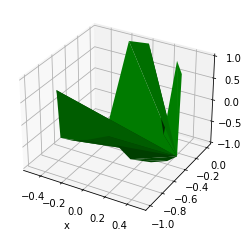

In [199]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# X = [0.2, 0.4, 0.6, 0.8, 0.3, 0.5, 0.7, 0.9];
# Y = [0.2, 0.4, 0.6, 0.8, 0.2, 0.4, 0.6, 0.8];
# Z = [0.2, 0.4, 0.6, 0.8, 0.2, 0.4, 0.6, 0.8];

theta = np.arange(0, (2*np.pi), 1/36*(2*np.pi));
phi = np.arange(0, (2*np.pi), 1/36*(2*np.pi));

X = 1 * np.sin(theta) * np.cos(phi)
Y = 1 * np.sin(theta) * np.sin(phi)
Z = 1 * np.cos(theta)

# print(X, Y)

z = np.append(np.zeros((1, 36)), np.ones((1, 36)))


ax.plot_trisurf(X, Y, Z, color='green', linewidth=0.1);
ax.set_xlabel('x');

plt.show()

In [16]:
#  Spectral Bandwidth

ew_bw = librosa.feature.spectral_bandwidth(ew_raw[0][0], sr=ew_fs);
ew_bw0 = librosa.feature.spectral_bandwidth(ew_raw[0][1], sr=ew_fs);
ew_bw1 = librosa.feature.spectral_bandwidth(ew_raw[0][2], sr=ew_fs);

mean_bw = np.mean((ew_bw, ew_bw0, ew_bw1), axis=0)

NameError: name 'ew_fs' is not defined

In [ ]:
times_nticks = np.min([ew_sc.shape[1], ew_sc0.shape[1], ew_sc1.shape[1]]);
times_nticks

In [ ]:
ew_sc_trim = ew_sc0[0,0:103];

In [ ]:
# ew_bw[0,0:times_nticks]
# mean_sc

In [ ]:
# fig, ax = plt.subplots(nrows=2, sharex=True)
fix, ax = plt.subplots()
times = librosa.times_like(ew_bw)
times1 = librosa.times_like(ew_bw0)
ax.set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax.legend()
ax.label_outer()
# librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
#                         y_axis='log', x_axis='time', ax=ax)


#  use with >1 subplot
# ax[0].set(title='log Power spectrogram')
# ax[0].fill_between(times, mean_sc[0] - mean_bw[0], mean_sc[0] + mean_bw[0],
#                   alpha=0.5, label='Centroid +- mean bandwidth')
# ax[0].plot(times, ew_sc[0], color='r')
# ax[0].plot(times, ew_sc0[0], color='g')
# ax[0].plot(times, ew_sc1[0], color='b')
# ax[0].plot(times, mean_sc[0], label='Mean Spect. Cent.', color='w')
# ax[0].legend(loc='upper left')

ax.set(title='log Power spectrogram')
ax.fill_between(times, mean_sc[0] - mean_bw[0], mean_sc[0] + mean_bw[0],
                  alpha=0.5, label='Centroid +- mean bandwidth')
ax.plot(times, ew_sc[0], color='r')
ax.plot(times, ew_sc0[0], color='g')
ax.plot(times, ew_sc1[0], color='b')
ax.plot(times, mean_sc[0], label='Mean Spect. Cent.', color='w')
ax.legend(loc='lower right')





librosa.display.specshow(librosa.amplitude_to_db(S0, ref=np.max),
                       y_axis='log', x_axis='time', ax=ax)
# ax[1].set(title='log Power spectrogram')
# ax[1].fill_between(times1, ew_sc0[0] - ew_bw0[0], ew_sc0[0] + ew_bw0[0],
#                   alpha=0.5, label='Centroid +- bandwidth')
# ax[1].plot(times, ew_sc0[0], label='Spectral centroid', color='w')
# ax[1].legend(loc='lower right')

# librosa.display.specshow(librosa.amplitude_to_db(S1, ref=np.max),
#                        y_axis='log', x_axis='time', ax=ax[2])
# ax[2].set(title='log Power spectrogram')
# ax[2].fill_between(times, ew_sc1[0] - ew_bw1[0], ew_sc1[0] + ew_bw1[0],
#                   alpha=0.5, label='Centroid +- bandwidth')
# ax[2].plot(times, mean_sc[0], label='Spectral centroid', color='w')
# ax[2].legend(loc='lower right')

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

img = librosa.display.specshow(librosa.amplitude_to_db(x,

                                                       ref=np.max),

                               y_axis='log', x_axis='time', ax=ax)

ax.set_title('Power spectrogram')

fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [ ]:
# Step 5: Analysis w/ unknown metric